In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
# fetch dataset 
solar_flare = fetch_ucirepo(id=89) 
  
# data (as pandas dataframes) 
X = solar_flare.data.features 
feature_names = X.columns.tolist()

# metadata 
print(solar_flare.metadata) 
  
# variable information 
print(solar_flare.variables) 


{'uci_id': 89, 'name': 'Solar Flare', 'repository_url': 'https://archive.ics.uci.edu/dataset/89/solar+flare', 'data_url': 'https://archive.ics.uci.edu/static/public/89/data.csv', 'abstract': 'Each class attribute counts the number of solar flares of a certain class that occur in a 24 hour period', 'area': 'Physics and Chemistry', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1389, 'num_features': 10, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['common flares', 'moderate flares', 'severe flares'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1989, 'last_updated': 'Wed Feb 14 2024', 'dataset_doi': '10.24432/C5530G', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'Notes:\r\n\r\n   -- The database contains 3 potential classes, one for the number of times a certain type of solar flare occured in a 24 hour period.\r\n   -- Each instance represents captur

In [2]:
import numpy as np
import torch

In [3]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoders for both categorical columns
le_largest_spot = LabelEncoder()
le_spot_distribution = LabelEncoder()
le_modified_zurich_class = LabelEncoder()

# Fit and transform the categorical columns
X['largest spot size'] = le_largest_spot.fit_transform(X['largest spot size'])
X['spot distribution'] = le_spot_distribution.fit_transform(X['spot distribution'])
X['modified Zurich class'] = le_spot_distribution.fit_transform(X['modified Zurich class'])

/tmp/ipykernel_1617260/4147510705.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['largest spot size'] = le_largest_spot.fit_transform(X['largest spot size'])
/tmp/ipykernel_1617260/4147510705.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['spot distribution'] = le_spot_distribution.fit_transform(X['spot distribution'])
/tmp/ipykernel_1617260/4147510705.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [4]:
X

,modified Zurich class,largest spot size,spot distribution,activity,evolution,previous 24 hour flare activity,historically-complex,became complex on this pass,area,area of largest spot
0,1,4,2,1,2,1,1,2,1,2
1,2,4,2,1,3,1,1,2,1,2
2,1,4,2,1,3,1,1,2,1,1
3,2,4,2,1,3,1,1,2,1,2
4,2,0,2,1,3,1,1,2,1,2
...,...,...,...,...,...,...,...,...,...,...
1384,5,4,3,1,2,1,1,1,1,1
1385,5,4,3,2,2,1,1,2,1,1
1386,1,4,2,1,2,1,2,2,1,1
1387,5,3,3,1,2,1,1,2,1,1


In [5]:
grouped_data = []

for _, group in X.groupby('modified Zurich class'):
    group_data = group.drop(columns=['modified Zurich class']).to_numpy()
    grouped_data.append(group_data)

In [6]:
datasets = grouped_data

In [7]:
len(datasets)

6

In [8]:
feature_names.remove('modified Zurich class')

In [9]:
feature_names

['largest spot size',
 'spot distribution',
 'activity',
 'evolution',
 'previous 24 hour flare activity',
 'historically-complex',
 'became complex on this pass',
 'area',
 'area of largest spot']

In [10]:
from src.ocsmm.OneClassSMMClassifier import OneClassSMMClassifier
classifier = OneClassSMMClassifier(nu=0.2)
classifier.fit(datasets)

Best gamma found.

kappa matrix calculated.

Found the alphas.



In [11]:
decision, y_pred = classifier.predict(datasets)

Calculating kappa...

calculatin rho
[0.63180367 0.6318028  0.63180354]


In [12]:
decision


array([ 3.37833774e-07,  7.18343631e-02,  9.81314047e-02,  2.62188520e-02,
       -5.37338894e-07,  1.99505121e-07])

In [13]:
y_pred

array([ 1.,  1.,  1.,  1., -1.,  1.])

In [14]:
outlier_indices = [i for i, value in enumerate(y_pred) if value == -1]
outlier_indices

[4]

In [15]:
from src.explanation_algorithms.OCSMMSHAP import OCSMMSHAP
ocsmm_shap = OCSMMSHAP(X=datasets, classifier=classifier, decision=decision)
ocsmm_shap.fit_ocsmmshap(X=datasets, num_coalitions=2**len(feature_names))

/home/swathi/OCSVM-SHAP/src/utils/shapley_procedure/coalitions.py:18: RuntimeWarning: divide by zero encountered in log2
  set_to_1 = np.floor(np.log2(rest)).astype(int)
/home/swathi/OCSVM-SHAP/src/utils/shapley_procedure/coalitions.py:18: RuntimeWarning: invalid value encountered in cast
  set_to_1 = np.floor(np.log2(rest)).astype(int)
/home/swathi/OCSVM-SHAP/src/utils/shapley_procedure/coalitions.py:18: RuntimeWarning: invalid value encountered in log2
  set_to_1 = np.floor(np.log2(rest)).astype(int)
Parallel projections:   0%|          | 0/511 [00:00<?, ?it/s]

Parallel projections: 100%|██████████| 511/511 [00:02<00:00, 172.90it/s]


In [16]:
shapley_values = ocsmm_shap.return_deterministic_shapley_values()

/home/swathi/micromamba/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


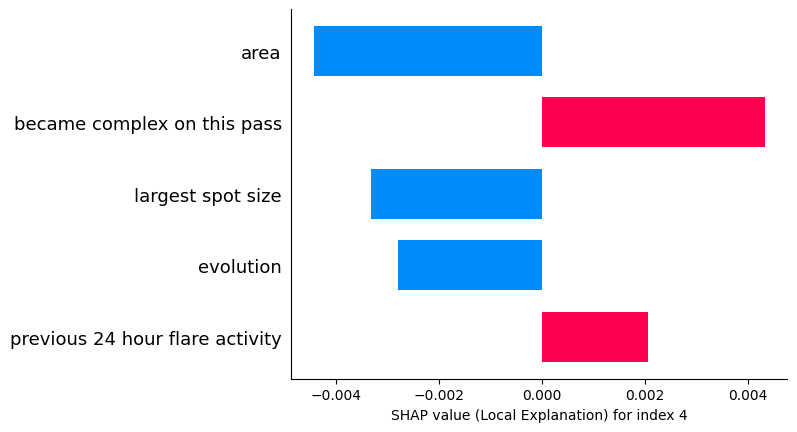

In [17]:
from src.utils.visualisation.deterministic_values import global_bar_plot, local_bar_plot
local_bar_plot(shapley_values, 4,  feature_names=feature_names)

/tmp/ipykernel_1617260/1214104310.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mean_abs_shap_values = np.abs(shapley_values.T).mean(axis=0)
/home/swathi/OCSVM-SHAP/src/utils/visualisation/deterministic_values.py:12: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  shap.bar_plot(shapley_values.T, show=False, max_display=5, **kwargs)


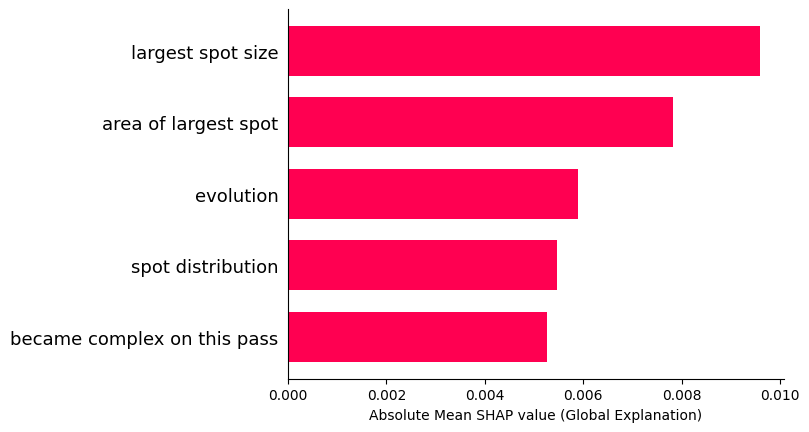

In [18]:
# global importance measure
mean_abs_shap_values = np.abs(shapley_values.T).mean(axis=0)  

# Call bar_plot for global explanation
global_bar_plot(mean_abs_shap_values, feature_names=feature_names)

/tmp/ipykernel_1617260/1469941899.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mean_abs_shap_values_outlier = np.abs(selected_shap_values).mean(axis=1)


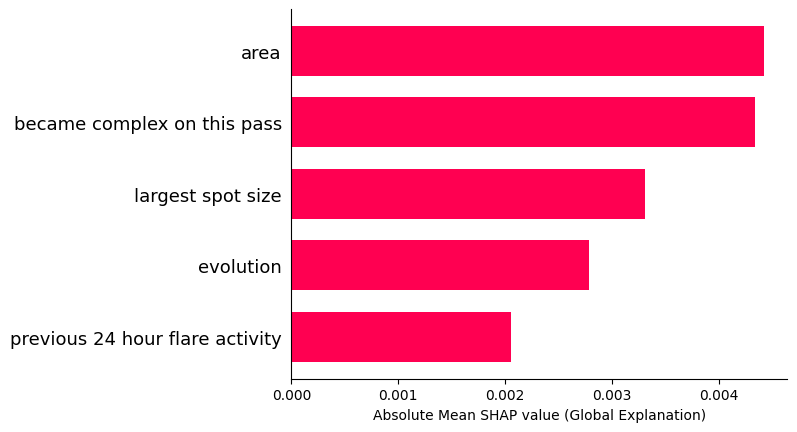

In [19]:
selected_shap_values = shapley_values[:,outlier_indices]
mean_abs_shap_values_outlier = np.abs(selected_shap_values).mean(axis=1) 
global_bar_plot(mean_abs_shap_values_outlier, feature_names=feature_names)

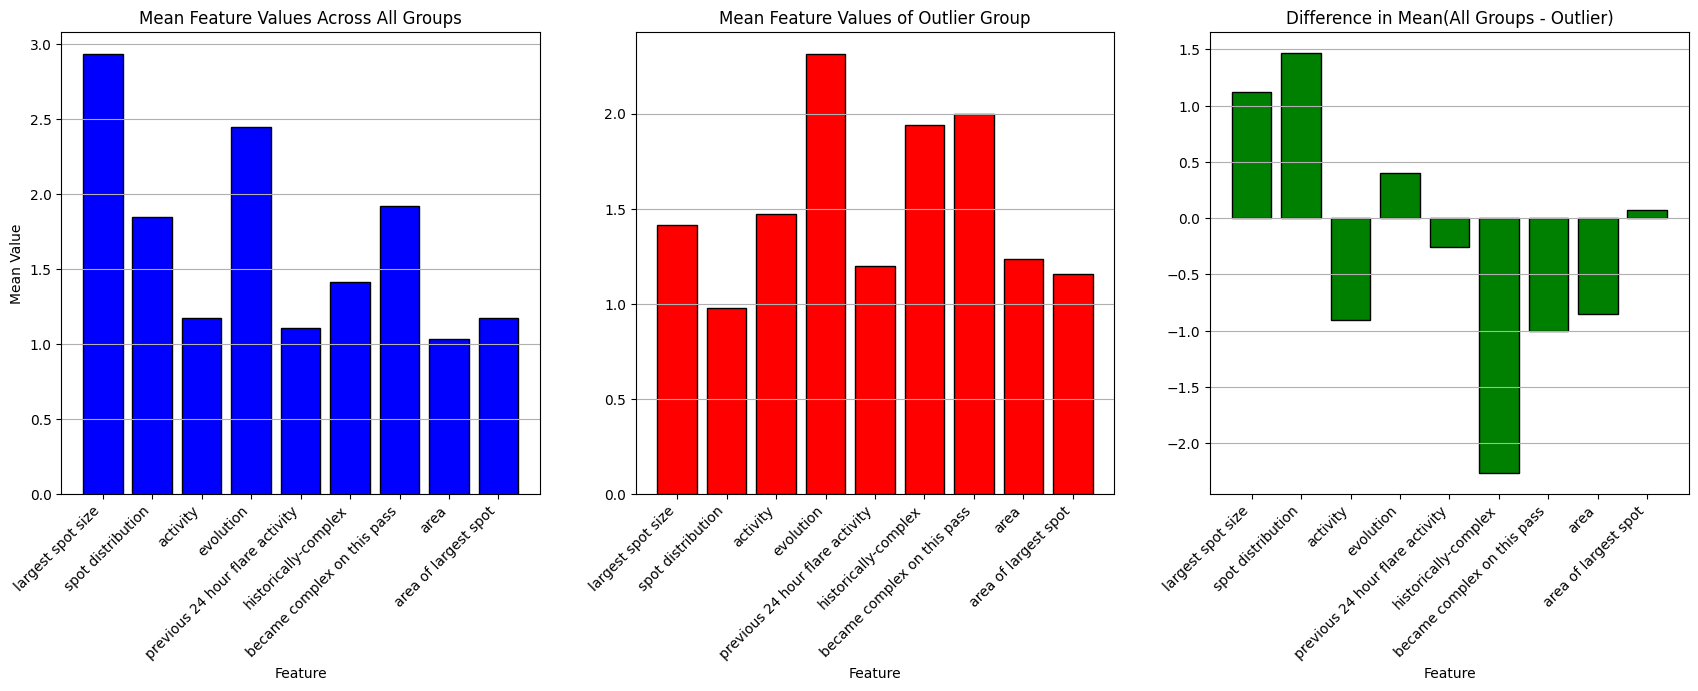

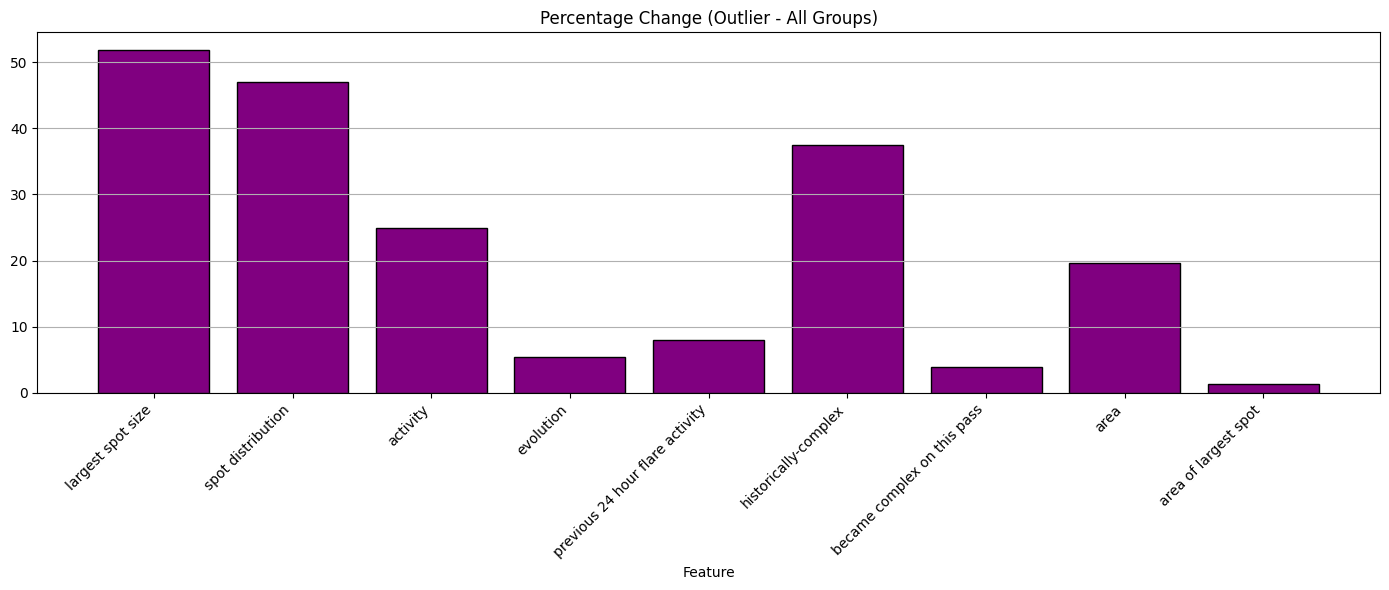

In [20]:
import matplotlib.pyplot as plt 
mean_all_groups = np.mean([np.mean(group, axis=0) for i, group in enumerate(datasets) if i != 4], axis=0)
std_deviation_all_groups = np.std([np.mean(group, axis=0) for i, group in enumerate(datasets) if i != 4], axis=0)
# Compute mean feature values for the outlier group
mean_outlier_group = np.mean(datasets[4], axis=0)
std_deviation_outlier_group = np.std(datasets[4], axis=0)

avg_std = (std_deviation_outlier_group+std_deviation_all_groups)/2
# Compute the delta between the two (outlier vs all groups)
difference_values =  (mean_all_groups - mean_outlier_group)/avg_std

percentage_change = abs((mean_outlier_group - mean_all_groups) / mean_all_groups) * 100

# Feature names for labeling
num_features = len(mean_all_groups)
x_labels = feature_names[:num_features]  # Adjust based on the number of features

# Plot histograms
fig, ax = plt.subplots(1, 3, figsize=(21, 6), sharey=False)

# Mean feature values for all groups (excluding outlier)
ax[0].bar(range(num_features), mean_all_groups, color='blue', edgecolor='black')
ax[0].set_xticks(range(num_features))
ax[0].set_xticklabels(x_labels, rotation=45, ha='right')
ax[0].set_title('Mean Feature Values Across All Groups')
ax[0].set_xlabel('Feature')
ax[0].set_ylabel('Mean Value')
ax[0].grid(axis='y')

# Mean feature values for the outlier group
ax[1].bar(range(num_features), mean_outlier_group, color='red', edgecolor='black')
ax[1].set_xticks(range(num_features))
ax[1].set_xticklabels(x_labels, rotation=45, ha='right')
ax[1].set_title('Mean Feature Values of Outlier Group')
ax[1].set_xlabel('Feature')
ax[1].grid(axis='y')

# Delta values (difference between the outlier group and all groups)
ax[2].bar(range(num_features), difference_values, color='green', edgecolor='black')
ax[2].set_xticks(range(num_features))
ax[2].set_xticklabels(x_labels, rotation=45, ha='right')
ax[2].set_title('Difference in Mean(All Groups - Outlier)')
ax[2].set_xlabel('Feature')
ax[2].grid(axis='y')

# ax[3].bar(range(num_features), percentage_change, color='purple', edgecolor='black')
# ax[3].set_xticks(range(num_features))
# ax[3].set_xticklabels(x_labels, rotation=45, ha='right')
# ax[3].set_title('Percentage Change (Outlier - All Groups)')
# ax[3].set_xlabel('Feature')
# ax[3].grid(axis='y')

fig, ax2 = plt.subplots(figsize=(14, 6))  # New figure for the percentage change plot
ax2.bar(range(num_features), percentage_change, color='purple', edgecolor='black')
ax2.set_xticks(range(num_features))
ax2.set_xticklabels(x_labels, rotation=45, ha='right')
ax2.set_title('Percentage Change (Outlier - All Groups)')
ax2.set_xlabel('Feature')
ax2.grid(axis='y')

plt.tight_layout()
plt.show()

In [21]:
X_scaled_df = pd.DataFrame(X, columns=X.columns)

grouped_data = []

for i, (_, group) in enumerate(X_scaled_df.groupby('modified Zurich class')):
    group_data = group.drop(columns=['modified Zurich class']).to_numpy()
    artificial_feature = np.ones((group_data.shape[0],1))  # Default value = 1
    if i == 1:  # and group has anomolous a_f
        artificial_feature.fill(5)
    
    group_data = np.hstack((group_data, artificial_feature))  # Append feature
    grouped_data.append(group_data)

In [22]:
feature_names.append('artificial_feature')

In [23]:
feature_names

['largest spot size',
 'spot distribution',
 'activity',
 'evolution',
 'previous 24 hour flare activity',
 'historically-complex',
 'became complex on this pass',
 'area',
 'area of largest spot',
 'artificial_feature']

In [24]:
datasets = grouped_data

In [25]:
datasets

[array([[5., 2., 1., ..., 1., 1., 1.],
        [5., 2., 1., ..., 1., 1., 1.],
        [5., 2., 1., ..., 1., 1., 1.],
        ...,
        [5., 1., 1., ..., 1., 1., 1.],
        [5., 2., 1., ..., 1., 1., 1.],
        [5., 2., 1., ..., 1., 1., 1.]], shape=(212, 10)),
 array([[4., 2., 1., ..., 1., 2., 5.],
        [4., 2., 1., ..., 1., 1., 5.],
        [3., 2., 1., ..., 1., 1., 5.],
        ...,
        [4., 2., 1., ..., 1., 1., 5.],
        [4., 2., 1., ..., 1., 1., 5.],
        [4., 2., 1., ..., 1., 1., 5.]], shape=(287, 10)),
 array([[4., 2., 1., ..., 1., 2., 1.],
        [4., 2., 1., ..., 1., 2., 1.],
        [0., 2., 1., ..., 1., 2., 1.],
        ...,
        [4., 2., 1., ..., 1., 1., 1.],
        [4., 2., 1., ..., 1., 1., 1.],
        [3., 2., 1., ..., 1., 1., 1.]], shape=(327, 10)),
 array([[2., 1., 2., ..., 1., 2., 1.],
        [0., 0., 1., ..., 1., 2., 1.],
        [4., 1., 1., ..., 1., 2., 1.],
        ...,
        [0., 1., 1., ..., 1., 1., 1.],
        [0., 2., 1., ..., 1., 1.,

In [26]:
from src.ocsmm.OneClassSMMClassifier import OneClassSMMClassifier

In [27]:
classifier = OneClassSMMClassifier(nu=0.43)

In [28]:
classifier.fit(datasets)

Best gamma found.

kappa matrix calculated.

Found the alphas.



In [29]:
decision, y_pred = classifier.predict(datasets)

Calculating kappa...

calculatin rho
[0.90236259 0.90236257 0.90236256 0.90236259]


In [30]:
y_pred

array([ 1., -1.,  1.,  1., -1.,  1.])

In [31]:
decision

array([ 1.25899317e-08, -8.47978299e-09,  1.43489923e-01,  3.80000648e-02,
       -1.51682999e-08,  1.10581514e-08])

In [32]:
outlier_indices = [i for i, value in enumerate(y_pred) if value == -1]
outlier_indices

[1, 4]

In [33]:
from src.explanation_algorithms.OCSMMSHAP import OCSMMSHAP
ocsmm_shap = OCSMMSHAP(X=datasets, classifier=classifier, decision=decision)
ocsmm_shap.fit_ocsmmshap(X=datasets, num_coalitions=2**len(feature_names))

/home/swathi/OCSVM-SHAP/src/utils/shapley_procedure/coalitions.py:18: RuntimeWarning: divide by zero encountered in log2
  set_to_1 = np.floor(np.log2(rest)).astype(int)
/home/swathi/OCSVM-SHAP/src/utils/shapley_procedure/coalitions.py:18: RuntimeWarning: invalid value encountered in cast
  set_to_1 = np.floor(np.log2(rest)).astype(int)
/home/swathi/OCSVM-SHAP/src/utils/shapley_procedure/coalitions.py:18: RuntimeWarning: invalid value encountered in log2
  set_to_1 = np.floor(np.log2(rest)).astype(int)
Parallel projections:   0%|          | 1/1023 [00:00<01:42,  9.96it/s]

Parallel projections: 100%|██████████| 1023/1023 [00:04<00:00, 250.16it/s]


In [34]:
shapley_values = ocsmm_shap.return_deterministic_shapley_values()

In [35]:
shapley_values

tensor([[-0.0084, -0.0045,  0.0355,  0.0046, -0.0066, -0.0020],
        [ 0.0006, -0.0031,  0.0198,  0.0002,  0.0049, -0.0037],
        [ 0.0008,  0.0016,  0.0090,  0.0024,  0.0020,  0.0023],
        [ 0.0070, -0.0031,  0.0227,  0.0080, -0.0073, -0.0097],
        [ 0.0009,  0.0021,  0.0052,  0.0063,  0.0024,  0.0012],
        [-0.0032,  0.0011,  0.0111,  0.0036,  0.0028,  0.0031],
        [ 0.0051,  0.0035,  0.0061,  0.0036,  0.0031, -0.0031],
        [ 0.0016,  0.0035,  0.0099,  0.0040, -0.0046,  0.0035],
        [-0.0099,  0.0085,  0.0141,  0.0030, -0.0005,  0.0027],
        [ 0.0056, -0.0096,  0.0097,  0.0025,  0.0039,  0.0058]])

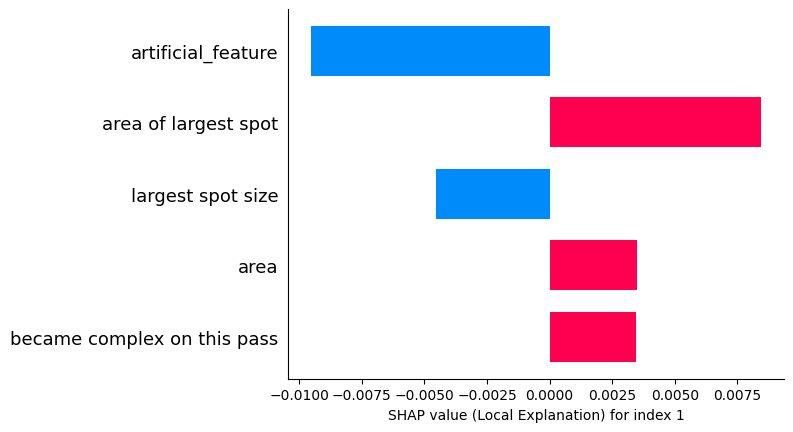

In [36]:
from src.utils.visualisation.deterministic_values import global_bar_plot, local_bar_plot
local_bar_plot(shapley_values, 1, feature_names=feature_names)

artificial feature is the highest contribution towars making this group an outlier.

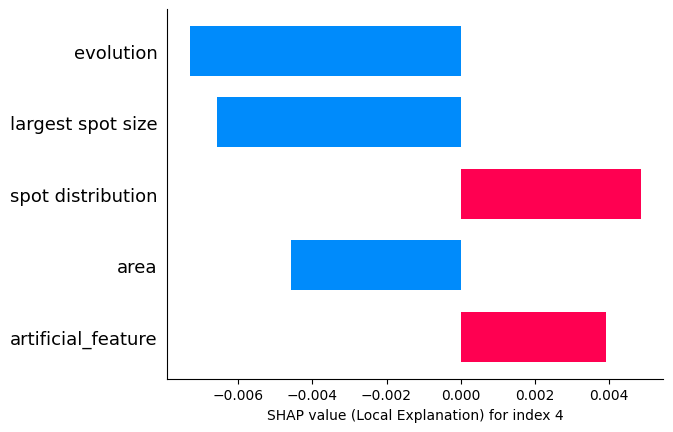

In [37]:
local_bar_plot(shapley_values, 4, feature_names=feature_names)

For the other outlier, it is caused due to other reasons(similar to first part) and not artificial_feature.

/tmp/ipykernel_1617260/1214104310.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mean_abs_shap_values = np.abs(shapley_values.T).mean(axis=0)


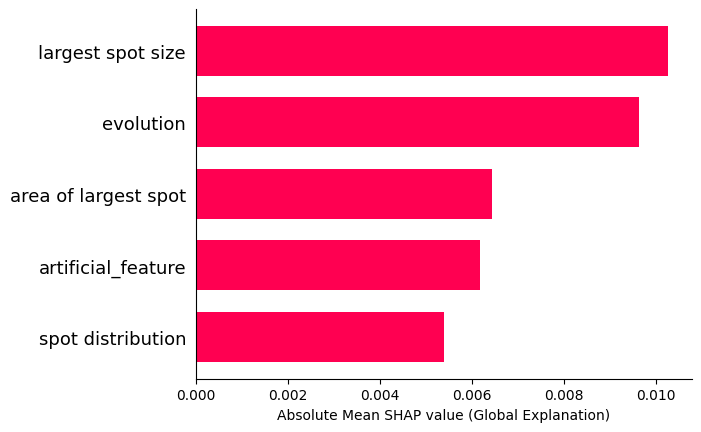

In [38]:
# global importance measure
mean_abs_shap_values = np.abs(shapley_values.T).mean(axis=0)  

# Call bar_plot for global explanation
global_bar_plot(mean_abs_shap_values, feature_names=feature_names)

/tmp/ipykernel_1617260/1469941899.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mean_abs_shap_values_outlier = np.abs(selected_shap_values).mean(axis=1)


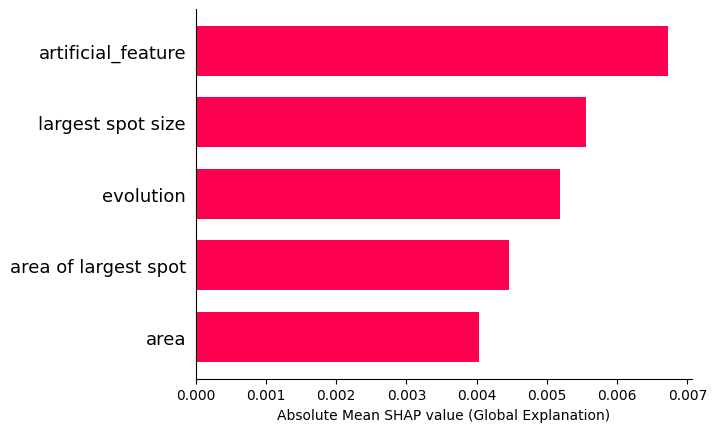

In [39]:
selected_shap_values = shapley_values[:,outlier_indices]
mean_abs_shap_values_outlier = np.abs(selected_shap_values).mean(axis=1) 
global_bar_plot(mean_abs_shap_values_outlier, feature_names=feature_names)